<h3>Библиотеки</h3>

Импортируем несколько библиотек которые мы будем использовать

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import IPython.display

import tensorflow as tf

<h4>Чтение файла</h4>

Прочитаем информацию из уже имеющегося временной ряд в структуру

In [78]:
df_std = pd.read_csv('DATA.csv',
                 delimiter=';',
                 low_memory=False)

<h4>Обработка</h4>

Обработаем временной ряд: уберем лишний столбец, и заполним некоторые столбцы 0, а некоторые столбцы его средним значением. В конце убедимся что датасет не содержит NULL значений

In [79]:
df_std = df_std.drop(['datetime'], axis=1)
print(df_std.isnull().sum())
df_std['winddir']=df_std['winddir'].fillna(0)
df_std['visibility']=df_std['visibility'].ffill()
df_std['snowdepth']=df_std['snowdepth'].fillna(0)
df_std['snow']=df_std['snow'].fillna(0)

precipcover_mean = df_std[df_std['preciptype'].notna()]['precipcover'].mean()
df_std['precipcover']=df_std['precipcover'].fillna(precipcover_mean)

df_std['sealevelpressure']=df_std['sealevelpressure'].ffill()

print(df_std.isna().sum())

tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipcover          103
preciptype          1616
snow                1826
snowdepth           1184
windspeed              0
winddir                0
sealevelpressure       2
cloudcover             0
visibility           571
solarradiation         0
solarenergy            0
uvindex                0
moonphase              0
conditions             0
description            0
dtype: int64
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipcover            0
preciptype          1616
snow                   0
snowdepth              0
windspeed              0
winddir                0
sealevelpres

Раскатегоризируем столбцы, чтобы модель лучше представляла вектор данных, убедимся что измененный временной ряд все еще не имеет NULL значений

In [80]:
enc = OneHotEncoder()
df_std = df_std.reset_index(drop=True)
df_0 = df_std[[name for i, name in enumerate(df_std.columns)]].drop(columns=['preciptype','conditions','description'])

df_std_type = pd.DataFrame(enc.fit_transform(df_std[['preciptype']]).toarray())
encoded_columns = enc.get_feature_names_out(['preciptype'])
df_std_type.columns = encoded_columns

df_std_conditions = pd.DataFrame(enc.fit_transform(df_std[['conditions']]).toarray())
encoded_columns = enc.get_feature_names_out(['conditions'])
df_std_conditions.columns = encoded_columns

df_std_description = pd.DataFrame(enc.fit_transform(df_std[['description']]).toarray())
encoded_columns = enc.get_feature_names_out(['description'])
df_std_description.columns = encoded_columns

df_std = df_0.join(df_std_type).join(df_std_conditions).join(df_std_description)

df_std.isnull().sum()

tempmax                                                                                 0
tempmin                                                                                 0
temp                                                                                    0
feelslikemax                                                                            0
feelslikemin                                                                            0
                                                                                       ..
description_Partly cloudy throughout the day with rain.                                 0
description_Partly cloudy throughout the day with snow clearing later.                  0
description_Partly cloudy throughout the day with snow in the morning and afternoon.    0
description_Partly cloudy throughout the day with snow.                                 0
description_Partly cloudy throughout the day.                                           0
Length: 11

<h4>Настройка моделей</h4>

Разобъем временной ряд на тренировочный, валидационный и тестовых значений для наших моделей

In [81]:
column_indices = {name: i for i, name in enumerate(df_std.columns)}

n = len(df_std)
train_df = df_std[0:int(n*0.7)]
val_df = df_std[int(n*0.7):int(n*0.9)]
test_df = df_std[int(n*0.9):]

num_features = df_std.shape[1]

print(num_features)

118


<h4>Окно данных</h4>

Создадим класс окна наших сетей, с помощью которого модель могла проще интерпретировать внутри себя данные, и быстрее обучаться

In [82]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = train_df,
               val_df = val_df,
               test_df = test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

<h4>Графики </h4>

Создадим функцию графиков наших сетей, для наглядного понимания работы

In [83]:
def plot(self, model=None, plot_col='temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

И функцию преобразования окна в окно входных данных и меток

In [84]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Итак, преобразуем наш временной ряд во внутренний датасет из пар

In [85]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Добавим свойства доступа к данным для окна датасета

In [86]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

<h4> Обучение моделей </h4>

Итак, перейдем к самому процессу обучения моделей:
максимальное количество эпох будет равно 10, "терпимость" равна 2, а метод оптимизации среднеквадратичной ошибки будем использовать Adam.

In [87]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

<h4>Модель базовой линии BaseLine</h4>

Попробуем начать с самой простой модели, которая "предсказывает" просто переставляя метку вперед на одно значение. Основывается принцип на том, что модель предполагает дальнейшее сохранение значений.

In [88]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1 ,
    label_columns=['temp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temp']

Инициализация самой модели

In [89]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Обучение модели и добавление меток оценки MSE и MAE

In [90]:
baseline = Baseline(label_index=column_indices['temp'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 6.9130 - mean_absolute_error: 1.9258


Выведем наглядно

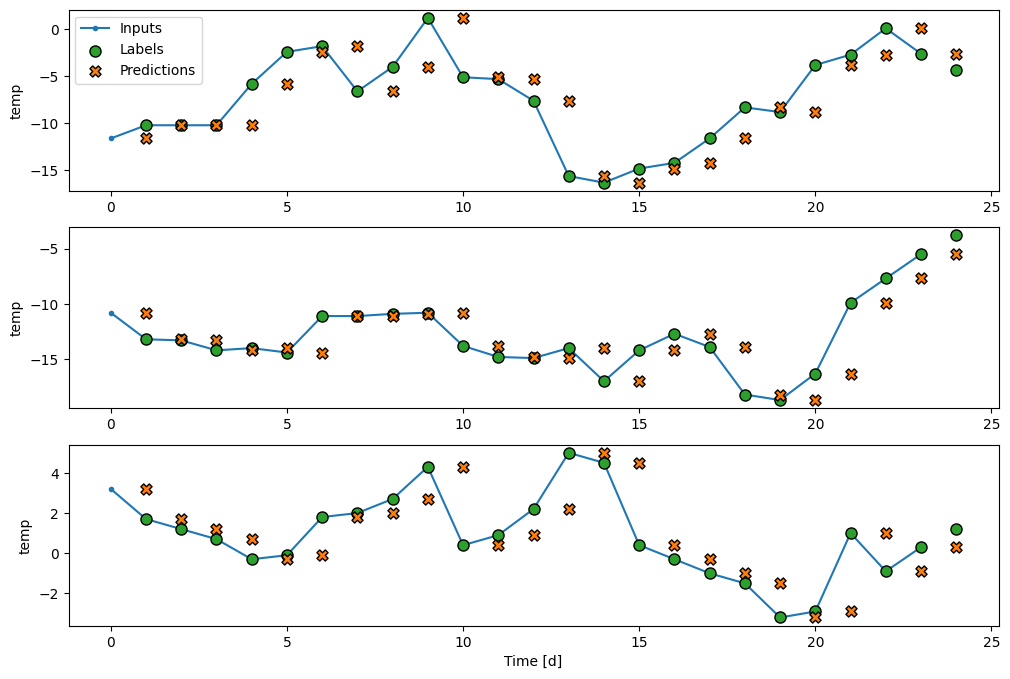

In [91]:
wide_window.plot(baseline)

<h4>Модель сверточной сети CNN </h4>

Попробуем с помощью нашего окна в 50 значений предсказывать со смещением на 1 вперед

Input shape: (32, 118, 118)


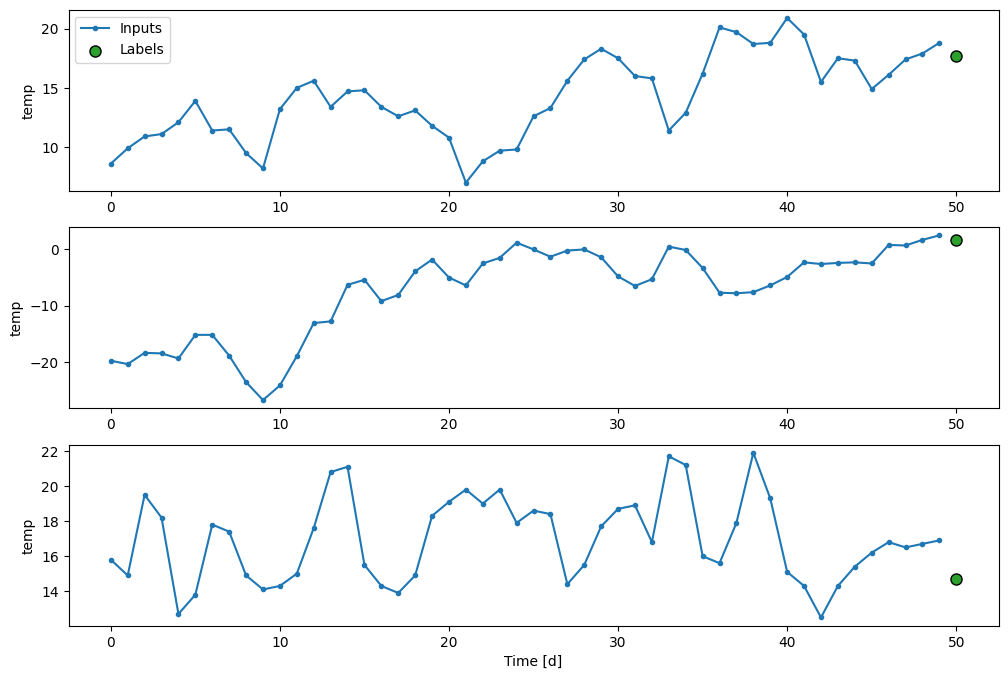

In [92]:
OUT_STEPS = 1
multi_window = WindowGenerator(input_width=50,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
multi_window.plot()
CONV_WIDTH = num_features
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['temp'])
conv_window
print('Input shape:', conv_window.example[0].shape)

Опишем модель CNN: с функцией активации relu, и 32 фильтрами на сверточном слое, и двумя внутренними плотными слоями.

Сразу покажем результат ее работы

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.1488 - mean_absolute_error: 3.9533


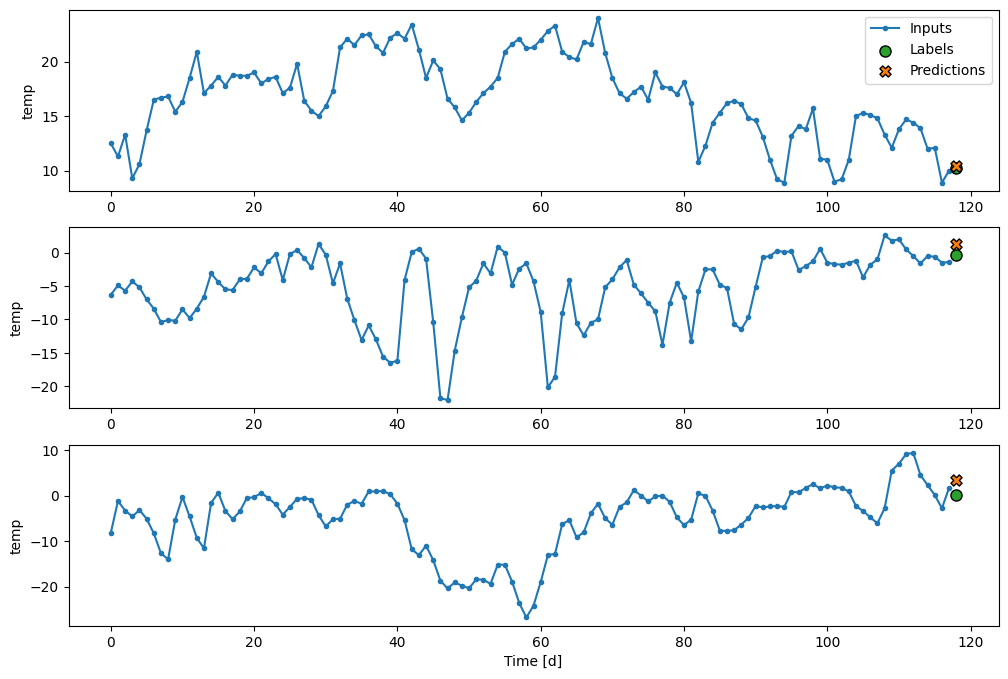

In [93]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=11, activation='relu'),
    tf.keras.layers.Dense(units=11, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.train)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_window.plot(conv_model)



Выведем фильтр-веса сверточной модели

Shape of convolutional layer weights: (118, 118, 32)


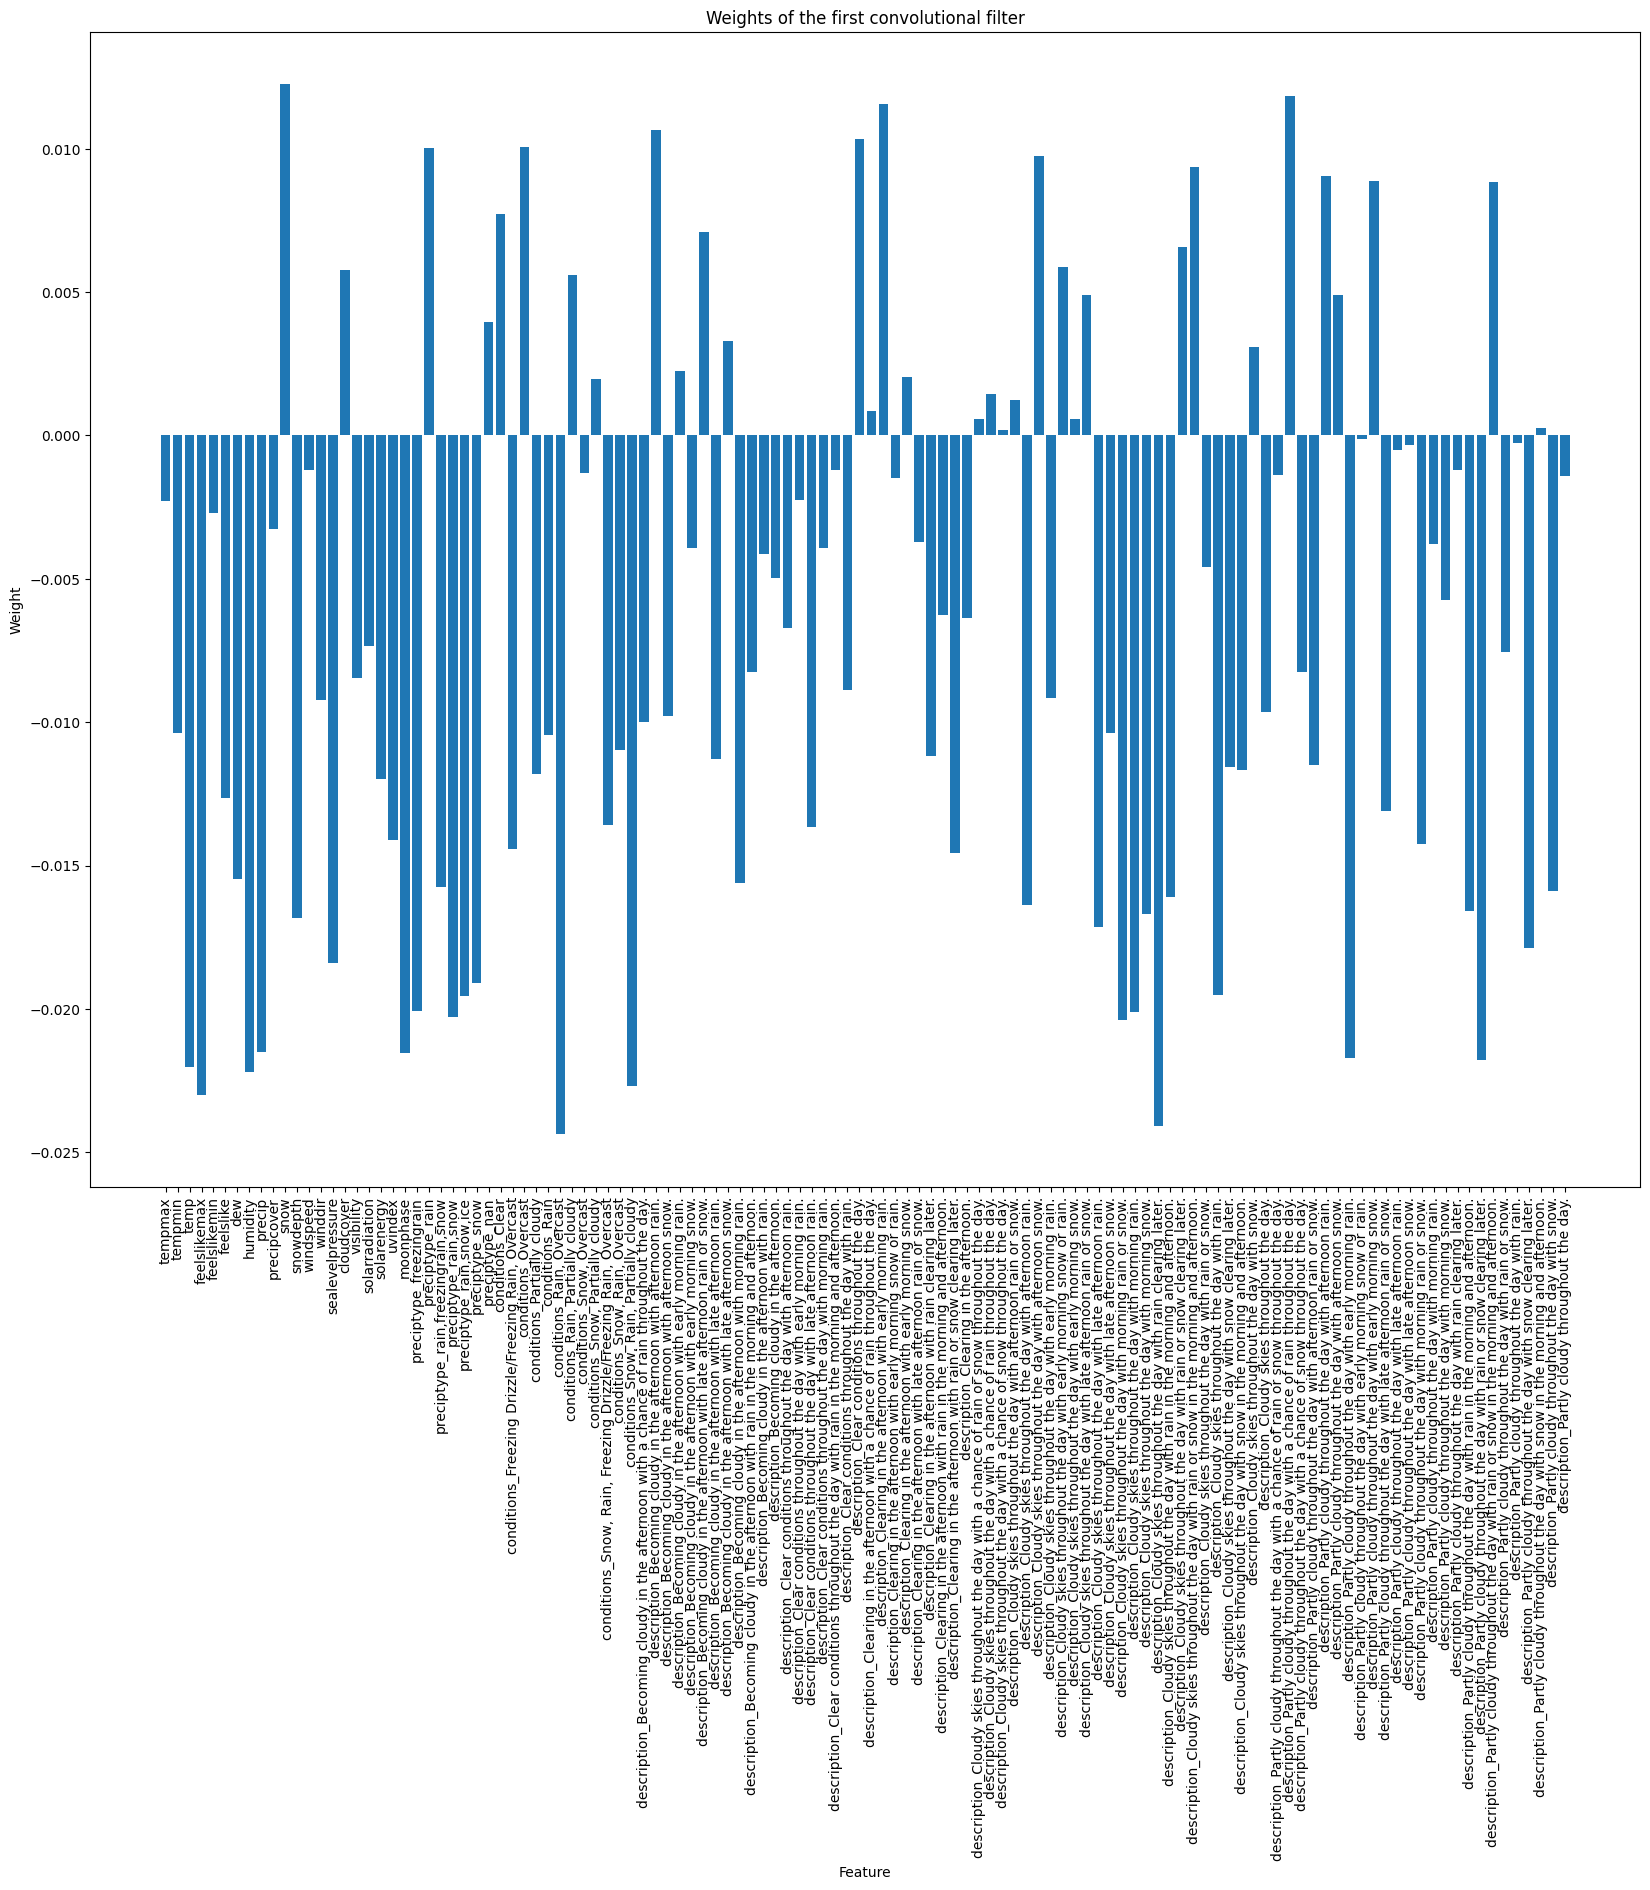

In [94]:
plt.figure(figsize=(20, 15))
conv_layer = conv_model.layers[0]
conv_weights = conv_layer.kernel.numpy()
print("Shape of convolutional layer weights:", conv_weights.shape)
# Для визуализации берем первый фильтр (первый столбец весов)
filter_weights = conv_weights[:, 0, 0]
# Теперь мы можем построить график
plt.bar(x=range(len(filter_weights)),
        height=filter_weights)
plt.xticks(range(len(train_df.columns)), train_df.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Weights of the first convolutional filter')
plt.show()

<h4>LSTM-модель</h4>

Попробуем long-short term model, нейроны которой передают информацию не только следующему слою, но и себе же в другой момент времени

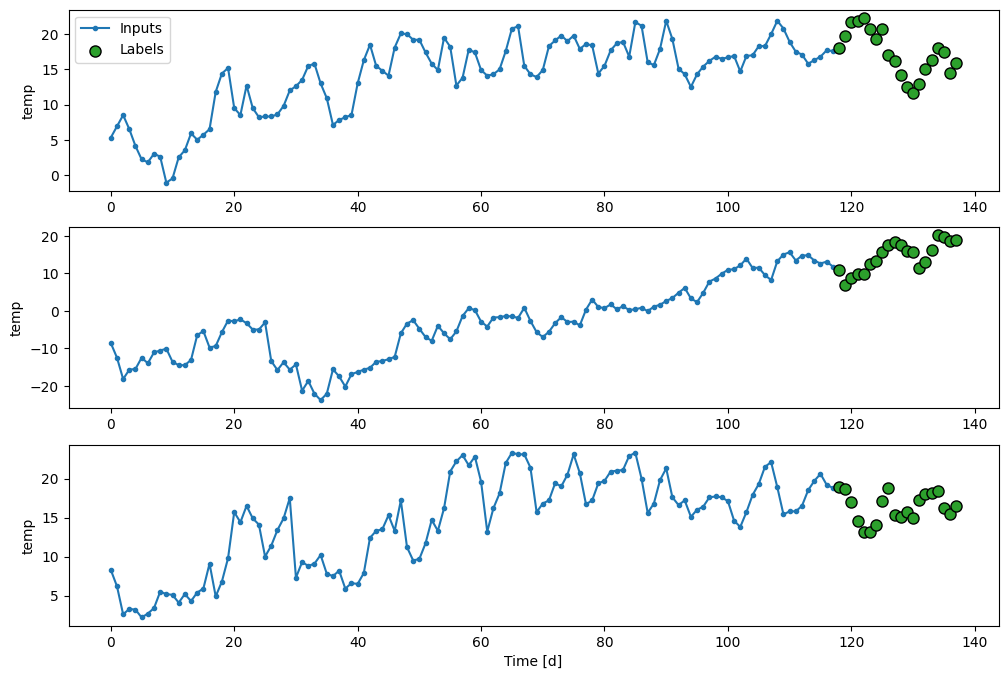

In [95]:
OUT_STEPS = 20
multi_window = WindowGenerator(input_width=num_features,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['temp'])
multi_window.plot()


Опишем саму модель с одним LSTM слоем, плотным внутренним слоем и слоем вывода. Покажем работу на примере данных

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 155.9296 - mean_absolute_error: 10.2789 - val_loss: 127.3676 - val_mean_absolute_error: 9.0676
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 117.5930 - mean_absolute_error: 8.8854 - val_loss: 97.7579 - val_mean_absolute_error: 7.8966
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 93.7496 - mean_absolute_error: 7.8909 - val_loss: 77.0913 - val_mean_absolute_error: 6.9948
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 74.0069 - mean_absolute_error: 6.8857 - val_loss: 61.4721 - val_mean_absolute_error: 6.2321
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 61.6065 - mean_absolute_error: 6.1923 - val_loss: 51.2339 - val_mean_absolute_error: 5.6925
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 51.6365 - mean_absolute_error: 5.5787 - val_loss: 43.4223 - val_mean_absolute_error: 5.2076
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 46.1896 - mean_absolute_error: 

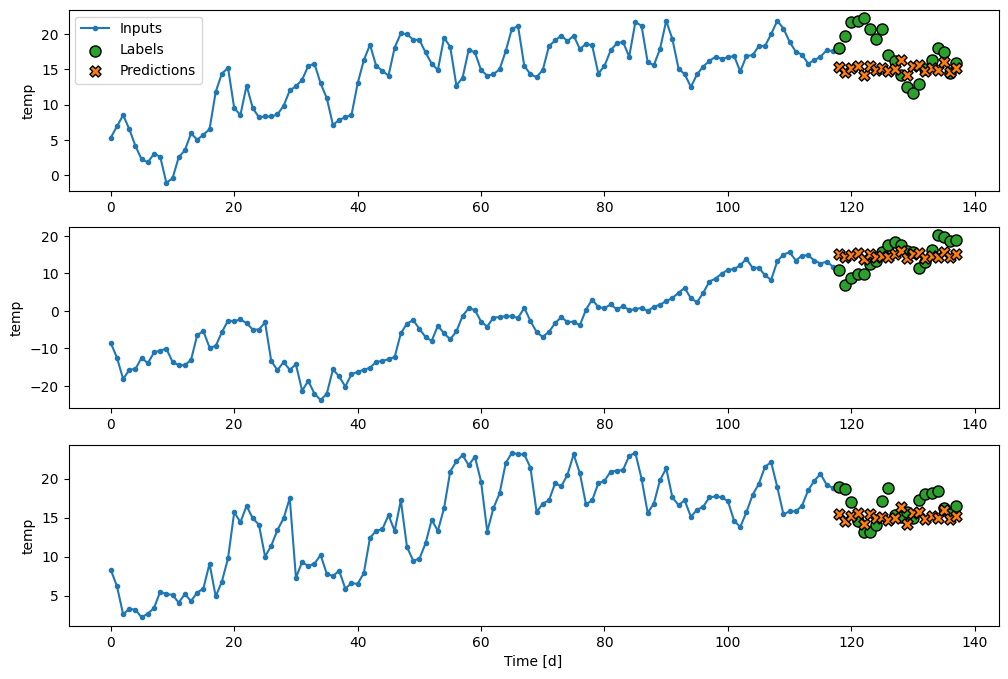

In [96]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(num_features, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(num_features * OUT_STEPS,
                          kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1,
                                                                                 maxval=1)),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_lstm_model, multi_window)
multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test,
                                                      verbose=0)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test,
                                                      verbose=0)
multi_window.plot(multi_lstm_model)




Выведем веса нейронов нашей LSTM модели

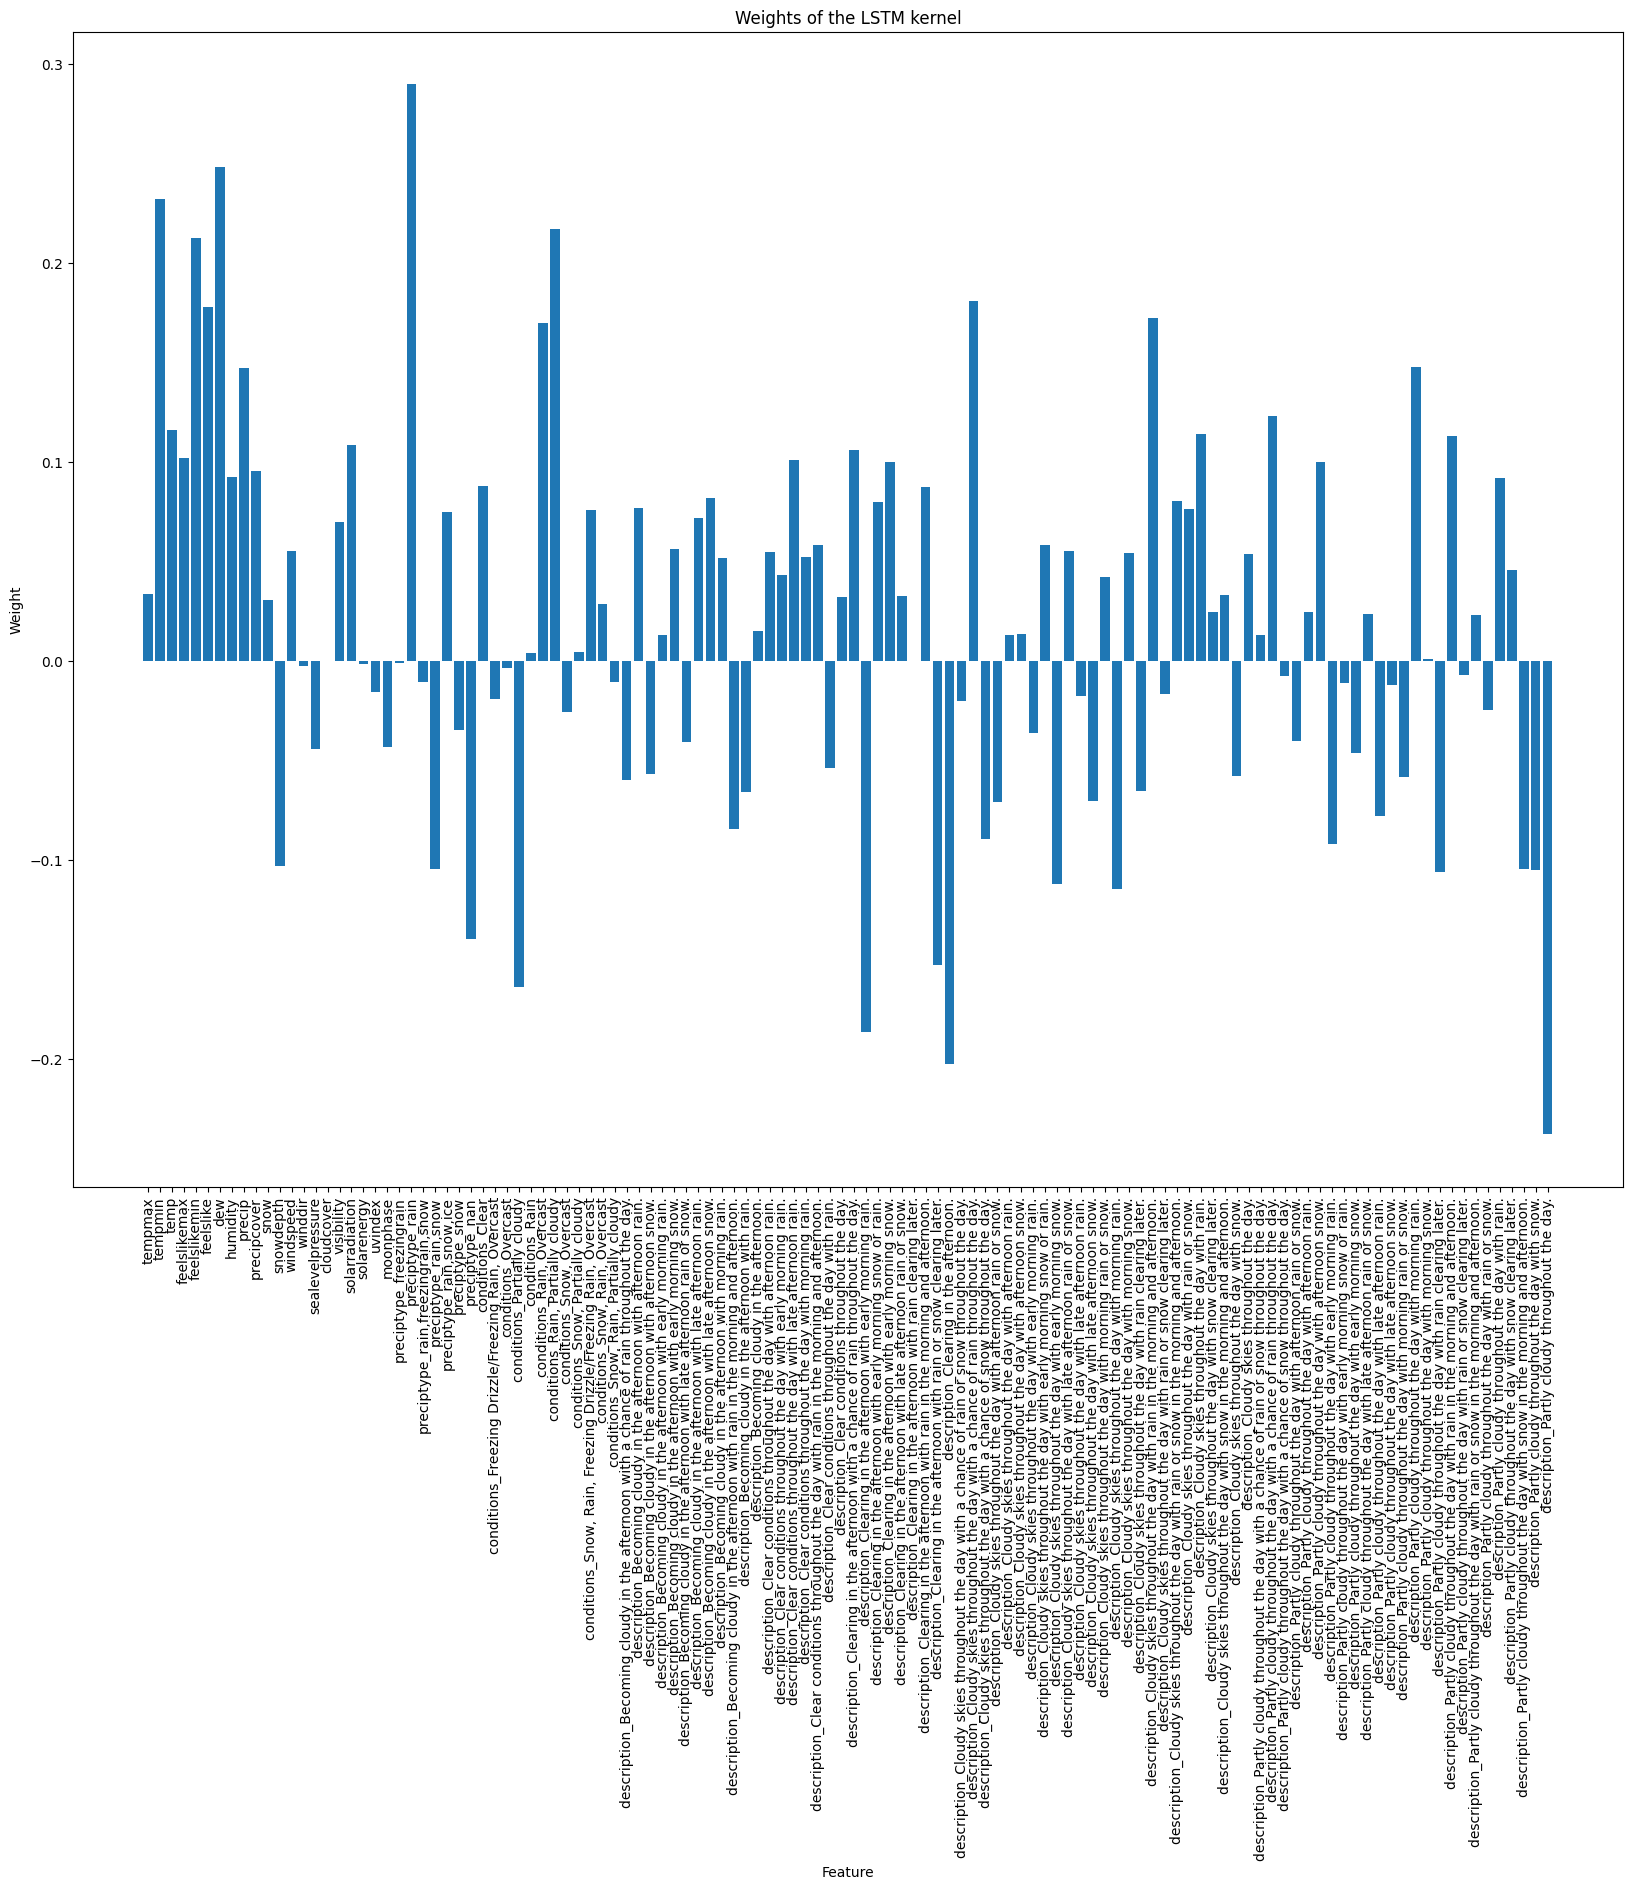

In [97]:
# Получаем kernel, recurrent_kernel и bias веса
lstm_layer = multi_lstm_model.layers[0]
weights = lstm_layer.get_weights()
kernel_weights, recurrent_kernel_weights, bias_weights = weights[0], weights[1], weights[2]
plt.figure(figsize=(20, 15))
plt.bar(x=range(kernel_weights.shape[0]),
        height=kernel_weights[:, 0])
plt.xticks(range(kernel_weights.shape[0]), train_df.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Weights of the LSTM kernel')
plt.show()